In [2]:
import matplotlib.pyplot as plt
import numpy as np
from tvb.simulator.lab import *

In [ ]:
# This first version of the code uses a simple 2-region connectivity matrix
# and runs the simulation in slices of 20 s each, for a total of 60 s.
# This version reconfigures for every slice, and saves the last state to set as initial conditions.


# 1) set connectivity matrices
connectivities = np.stack([
    np.array([[1.0, 0.2],
              [0.2, 1.0]]),
    np.array([[1.0, 0.5],
              [0.5, 1.0]]),
    np.array([[1.0, 0.8],
              [0.8, 1.0]])
], axis=2)  # shape (2, 2, 3)

# 2) Simulation parameters
total_duration = 60_000.0        # ms (60 s)
n_slices      = connectivities.shape[2]
slice_dur     = total_duration / n_slices  # 20 000 ms
dt            = 1.0              # integrator time‐step in ms
prev_state    = None            # initial conditions for the first slice

# 3) Prepare lists to collect each slice’s BOLD output
bold_times = []
bold_data_list  = []
tavg_times_list =[]
tavg_data_list = []

labels = np.array(["R1", "R2"], dtype="<U128")

# 4) Run the simulation in slices
for k in range(n_slices):
    # Extract the kᵗʰ connectivity matrix
    mat = connectivities[:, :, k]

    # Build a TVB Connectivity object
    conn = connectivity.Connectivity(
        weights=mat,
        tract_lengths=np.ones_like(mat),
        region_labels=labels,
        centres=np.array([[0, 0, 0], [1, 0, 0]])  # Dummy 3D coordinates for 2 regions
    )

    # Configure the simulator for this slice
    sim = simulator.Simulator(
        model=models.Generic2dOscillator(),   # pick the model you want
        connectivity=conn,
        coupling=coupling.Linear(a=np.array([0.0126])),
        integrator=integrators.HeunStochastic(
            dt=dt,
            noise=noise.Additive(nsig=np.array([0.001]))),
        monitors=(
            monitors.TemporalAverage(period=dt),
            monitors.Bold(period=1000.0),
            monitors.Raw(period=slice_dur) 
        ),
        simulation_length=slice_dur,  # 20 s per slice
    ).configure()

    if prev_state is not None:
        sim.initial_conditions = prev_state

    print(f"Running slice {k+1} with connectivity weights:\n{sim.connectivity.weights}")

    (tavg_time, tavg_data), (bold_time, bold_data), (st_time, st_data) = sim.run()

    # Shift this slice’s times so they “follow on” from previous slices
    bold_times.append(bold_time + k * slice_dur)
    bold_data_list.append(bold_data)
    tavg_times_list.append(tavg_time + k * slice_dur)
    tavg_data_list.append(tavg_data)
    prev_state = st_data[-1]
    

# 5) Concatenate all slices into one continuous 60 s output
full_bold_time = np.concatenate(bold_times)
full_bold_data = np.concatenate(bold_data_list, axis=0)
full_tavg_time = np.concatenate(tavg_times_list)
full_tavg_data = np.concatenate(tavg_data_list, axis=0)

print(full_tavg_time)

# full_bold_time is a 1D array of length ~60 s/1 s = 60 points
# full_bold_data is shape (60, 2, …) depending on your Bold monitor settings


Running slice 1 with connectivity weights:
[[1.  0.2]
 [0.2 1. ]]
Running slice 2 with connectivity weights:
[[1.  0.5]
 [0.5 1. ]]
Running slice 3 with connectivity weights:
[[1.  0.8]
 [0.8 1. ]]
[5.00000e-01 1.50000e+00 2.50000e+00 ... 5.99975e+04 5.99985e+04
 5.99995e+04]


Text(0.5, 0, 'Time (ms)')

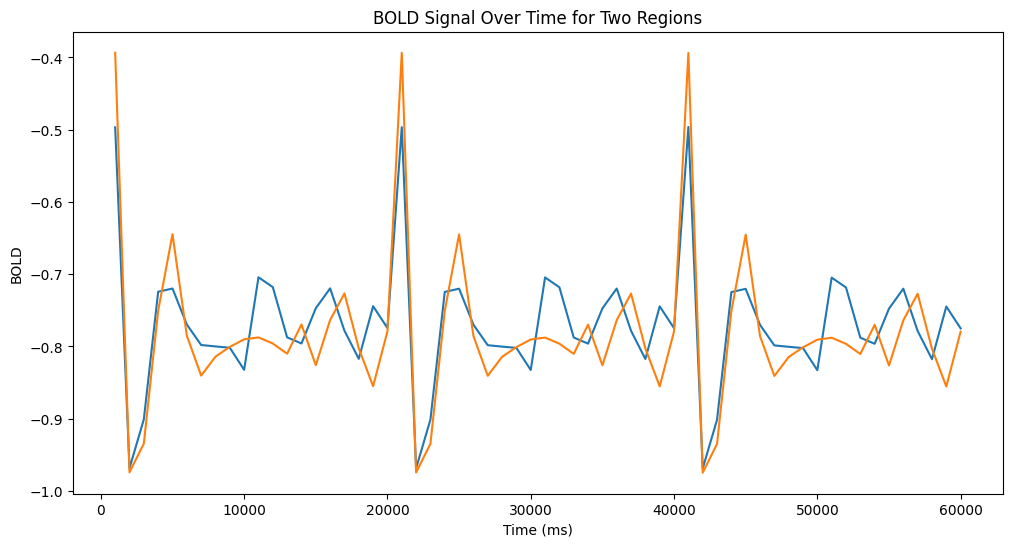

In [13]:
plt.figure(figsize=(12, 6))

plt.plot(full_bold_time, full_bold_data[:, 0, :, 0])
plt.ylabel("BOLD")
plt.title("BOLD Signal Over Time for Two Regions")
plt.xlabel('Time (ms)')

Text(0.5, 0, 'Time (ms)')

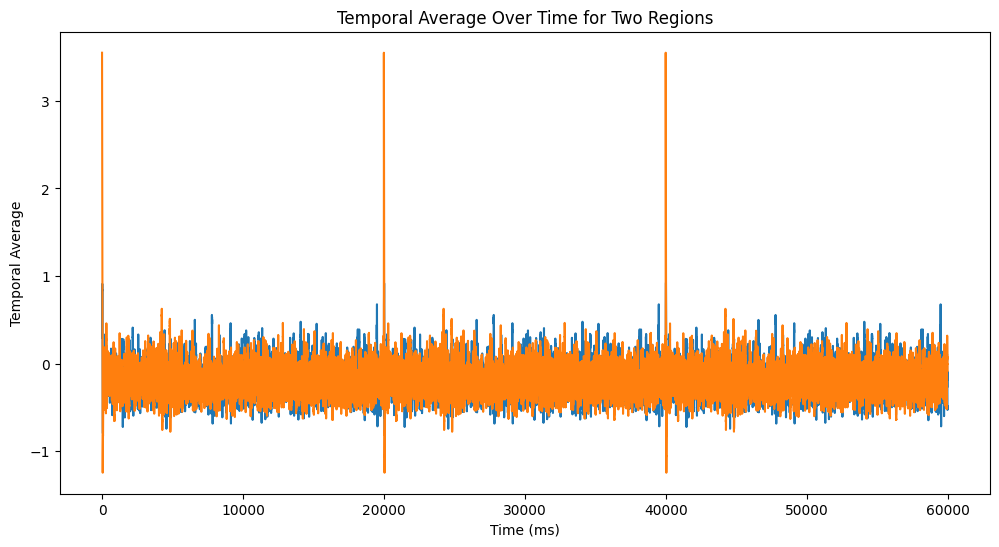

In [10]:
plt.figure(figsize=(12, 6))

plt.plot(full_tavg_time, full_tavg_data[:, 0, :, 0])
plt.ylabel("Temporal Average")
plt.title("Temporal Average Over Time for Two Regions")
plt.xlabel('Time (ms)')